# Reservoir Comparison

This notebook compares classical and quantum reservoir computing.

---

This file is part of the `QuantumReservoirPy` project.

Last Updated: `2023-09-27`

Using Version: `0.1`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import reservoirpy as rpy

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.plot import feature_plotter
from quantumreservoirpy.reservoirs import Static

from reservoirpy.nodes import Input, Reservoir as ClassicalReservoir, Ridge

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

We will construct a classical reservoir and a quantum reservoir with similar characteristics, and then use both on a common sequence to analyze the differences in performance.

##### Common Variables

We will use the same sequence for both reservoirs.

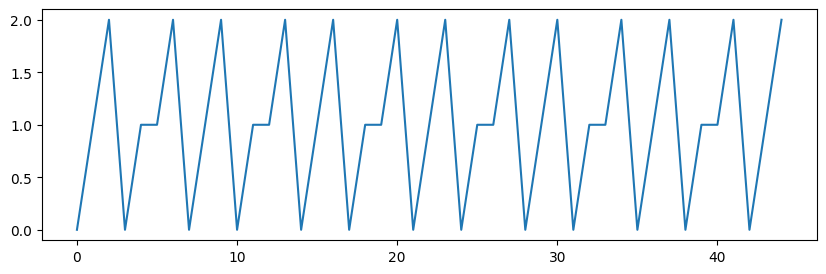

In [2]:
sequence = np.array([0, 1, 2, 0, 1, 1, 2] * 25)

plt.figure(figsize=(10, 3))
plt.plot(sequence[:45])
plt.show()

---

## Classical Reservoir

We will use the `reservoirpy` package to create and evaluate a classical reservoir. See [their documentation](https://reservoirpy.readthedocs.io/) for a comprehensive guide on how to set this up.

In [3]:
rpy.verbosity(0)
rpy.set_seed(171)

num_neurons = 2 ** 5

We can run the classical reservoir on our sequence and train an echo state network.

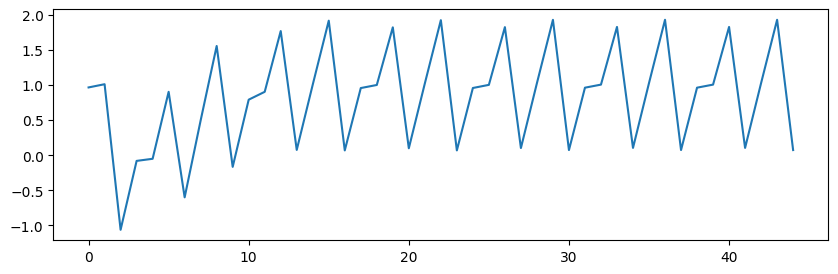

In [4]:
classical_seq = np.resize(sequence, (45, 1))
classical_esn = Input(input_dim=1) >> ClassicalReservoir(num_neurons, lr=0.5, sr=0.9) >> Ridge(ridge=1e-6)
classical_esn.fit(classical_seq, np.roll(classical_seq, -1))

classical_predictions = classical_esn.run(classical_seq)

plt.figure(figsize=(10, 3))
plt.plot(classical_predictions)
plt.show()

The classical reservoir is able to roughly replicate the sequence. Repeated trials shows that some ESNs work better than others.

---

## Quantum Reservoir

We will construct a `Static` quantum reservoir with a random unitary.

In [5]:
num_qubits = 5
operator = random_unitary(2 ** num_qubits, seed=417)
backend = AerSimulator()

We will measure the first two qubits and leave 3 ancillary qubits between each step in the sequence. During each step in the sequence, we will only initialize the second qubit and leave the first qubit as the measured state from the preceding step.

This was determined by trial and error to produce optimal results with the given seed for the random unitary.

In [6]:
class QuantumReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.initialize(int(timestep % 2), 1)
        circuit.append(operator, circuit.qubits)
        circuit.measure([0, 1])
    

We can create and run a `QuantumReservoir` on the `AerSimulator` backend.

Running reservoirs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:29<00:00, 89.01s/it]


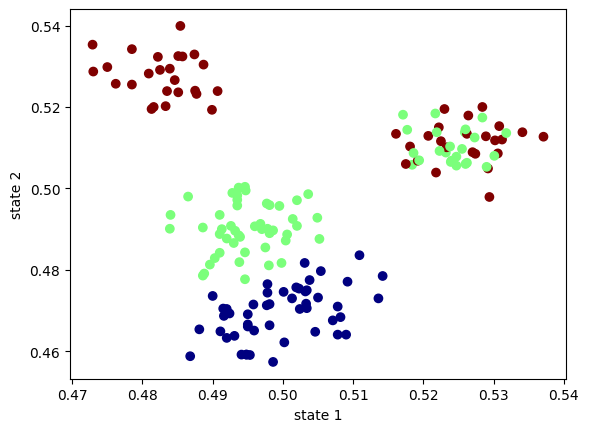

In [7]:
quantum_res = QuantumReservoir(n_qubits=num_qubits, backend=backend)
quantum_data = quantum_res.run(timeseries=sequence, shots=10000)

warmup = 5
x = quantum_data.reshape(-1, 2)[warmup:]
y = np.roll(sequence.reshape(-1), -1)[warmup:]
feature_fig, feature_ax = feature_plotter(x, y)

The features produced by the sequence are mostly able to distinguish between the distinct values of the sequence.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=33)

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
print("KNN Classifier Score:", model.score(X_test, y_test))

quantum_predict_knn = quantum_res.predict(
    num_pred=45,
    model=model,
    from_series=sequence,
    shots=10000
)

plt.figure(figsize=(10, 3))
plt.plot(quantum_predict_knn)
plt.show()

KNN Classifier Score: 0.7543859649122807


Predicting...:  16%|█████████████████████▎                                                                                                                   | 7/45 [15:17<1:23:19, 131.58s/it]

The predictions produced by the quantum reservoir are able to adopt some of the features of the original sequence.